In [1]:
import os
import gzip
import hashlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import requests
import matplotlib.pyplot as plt
import numpy as np
from torch import tensor, optim
from tqdm import trange
from torchvision import transforms
np.set_printoptions(suppress=True)

In [2]:
def imshow(img):
    plt.imshow(img)
    plt.show()
    
def plot(data):
    plt.plot(data)
    plt.show()

In [3]:
# data starts at offset 16
x_train_url = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
x_test_url = 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'

# data starts at index 8
y_train_url = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
y_test_url = 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'

In [8]:
def fetch(url):
    if not os.path.isdir('data'):
        os.mkdir('data')
    fp = md5 = 'data/' + hashlib.md5(url.encode()).hexdigest()
    if os.path.isfile(fp):
        with open(fp, 'rb') as f:
            dat = f.read()
    else:
        with open(fp, 'wb') as f:
            res = requests.get(url)
            res.raise_for_status()
            dat = res.content
            f.write(dat)
    assert b'503' not in dat, 'request failed'
    return np.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

In [9]:
# download datasets
x_train = fetch(x_train_url)[16:].reshape(-1, 28*28)
y_train = fetch(y_train_url)[8:]

x_test = fetch(x_test_url)[16:].reshape(-1, 28*28)
y_test = fetch(y_test_url)[8:]

3


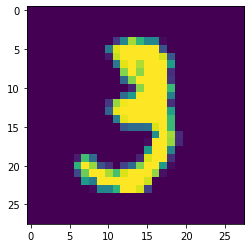

In [10]:
i = 10
img = x_train[i]
print(y_train[i])
plt.imshow(img.reshape(28, 28))
plt.show()

In [11]:
# setup
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(784, 128)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x

Loss: 0.22 Accuracy: 0.93: 100%|██████████| 500/500 [00:01<00:00, 311.67it/s]


finished training


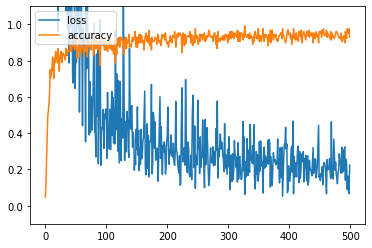

In [193]:
model = Net()

# train
epochs = 500
batch_size = 128
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
losses, accs = [], []
for i in (t := trange(epochs)):
    # batch
    idx = np.random.randint(0, x_train.shape[0], size=(batch_size))
    x = tensor(x_train[idx]).float()
    y = tensor(y_train[idx]).long()
    
    optimizer.zero_grad()
    out = model(x)
    loss = loss_func(out, y)
    loss.backward()
    optimizer.step()

    acc = torch.div(torch.sum(torch.argmax(out, dim=1) == y), batch_size)

    losses.append(loss.detach().numpy())
    accs.append(acc.detach().numpy())
    t.set_description(f'Loss: {loss:.2f} Accuracy: {acc:.2f}')

print('finished training')

plt.ylim(-0.1, 1.1)
plt.plot(losses, label='loss')
plt.plot(accs, label='accuracy')
plt.legend(loc='upper left')
plt.show()

In [13]:
# pytorch eval
y_test_pred = torch.argmax(model(torch.tensor(x_test).float()), dim=1).numpy()
(y_test == y_test_pred).mean()

0.9325

In [88]:
# copy weights from pytorch
l1 = model.l1.weight.detach().numpy().T
l2 = model.l2.weight.detach().numpy().T

# numpy forward pass
def forward(x):
    x = x.dot(l1)
    x = np.maximum(x, 0)
    x = x.dot(l2)
    return x

# numpy eval
y_test_preds_out = forward(x_test)
y_test_preds = np.argmax(y_test_preds_out, axis=1)
(y_test == y_test_preds).mean()

0.9326

In [89]:
# uncertainty
ret = -y_test_preds_out[range(y_test_preds_out.shape[0]), y_test] + np.log(np.exp(y_test_preds_out).sum())
np.argmax(ret)

1014

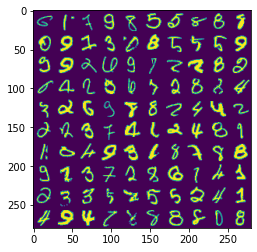

In [163]:
g = 10
grid = x_test[np.argsort(ret)[0:g**2]]
grid = np.concatenate(grid.reshape(g, g*28, 28), axis=1)
imshow(grid)

In [184]:
# initialize a nn layer
def layer(m, n):
    # normal distribution
    return np.random.normal(0, 1, size=(m, n)).astype(np.float32)

In [191]:
np.random.seed(1323)
l1 = layer(784, 128)
l2 = layer(128, 10)
l1.shape, l2.shape

((784, 128), (128, 10))

In [235]:
def relu(x):
    # np.maximum compares elementwise across all elements
    return np.maximum(x, 0)

def forward(x):
    x = x.dot(l1)
    x = relu(x)
    x = x.dot(l2)
    return x

def compute_loss(y_pred, y_actual):
    return np.square(y_actual - y_pred).mean(dtype=np.float32)

def compute_grads():
    pass

In [244]:
# numpy train
epochs = 500
lr = 0.001
batch_size = 128
losses, accs = [], []
for i in (t := trange(epochs)):
    # batch
    idxs = np.random.randint(0, x_train.shape[0], size=(batch_size))
    x, y = x_train[idxs], y_train[idxs]
    
    # forward pass, predict using current weights
    l2 = forward(x)
    y_pred = np.argmax(l2, axis=1)
    acc = (y == y_pred).mean()

    # compute loss
    loss = compute_loss(y_pred, y)

    # backward pass -- compute gradients
    pass

    # adjust weights using SGD
#     l1 = l1 - lr * d_l1
#     l2 = l2 - lr * d_l2

    # stats
    losses.append(loss)
    accs.append(acc)
    t.set_description(f'Loss: {loss:.2f} Accuracy: {acc:.2f}')
    
plot(losses, acc)

Loss: 28.28 Accuracy: 0.12: 100%|██████████| 500/500 [00:00<00:00, 706.89it/s]


TypeError: plot() takes 1 positional argument but 2 were given

In [205]:
idxs = np.random.randint(0, x_train.shape[0], size=(batch_size))
y = y_train[idxs]
y

array([0, 7, 0, 5, 0, 2, 2, 0, 5, 2, 7, 3, 5, 9, 6, 9, 7, 3, 4, 6, 4, 4,
       0, 0, 5, 2, 5, 6, 2, 0, 7, 3, 1, 2, 6, 5, 3, 6, 3, 4, 6, 1, 8, 7,
       8, 5, 7, 1, 1, 0, 5, 3, 0, 6, 5, 8, 4, 2, 3, 3, 8, 9, 2, 3, 8, 1,
       1, 7, 9, 8, 1, 9, 4, 0, 4, 0, 2, 4, 8, 6, 3, 0, 3, 9, 3, 1, 0, 1,
       7, 2, 6, 7, 1, 0, 8, 4, 2, 3, 8, 7, 0, 9, 1, 4, 9, 1, 5, 7, 8, 2,
       9, 6, 3, 6, 0, 6, 3, 3, 4, 8, 9, 4, 0, 6, 9, 6, 5, 3], dtype=uint8)

In [211]:
test = np.zeros((len(y), 10), np.float32)
test[range(test.shape[0]), y] = 1
test

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)